#### Load necessary packages

In [1]:
import os
import sys
sys.path.insert(0,'../../mocsy')

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm
import pickle 
import random
import matplotlib.pyplot as plt
from scipy import stats

import mocsy
from mocsy import mvars
from mocsy import mrhoinsitu
from mocsy import mrho

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Creation of the four training data sets

#### Read in the observational data

In [4]:
print("for tos, use the ESA CCI and C3S product until October 2022, then Armor3D for November and December")
print("for siconc, use the ESA CCI and C3S product until October 2022, then METOFFICE Ostia for November and December")
print("for chlos, use the climatological mean value before September 1997")
print("for co2, use a global representative value, given by the annual average measurement from Manua Loa, Hawaii")
ds_cci = xr.open_dataset("../data/ESACCI_and_C3S-GLO-SST-L4-REP-OBS-SST_multi-vars_1x1grid_1982-01-01-2022-10-31_monmean.nc"
                    ).sel(time=slice('1993-01-01', '2022-10-31'))
ds_ostia = xr.open_dataset("../data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_multi-vars_1x1grid_2022-11-01-2022-12-31_monmean.nc")
ds_armor = xr.open_dataset("../data/dataset-armor-3d-rep-monthly_multi-vars_1x1grid_coarsened_0.00m_1993-01-01-2022-12-01.nc")
ds_ssh = xr.open_dataset(
    "../data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_adt_1x1grid_coarsened_1993-01-01-2022-12-31_monmean.nc")
ds_globcol = xr.open_dataset("../data/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_1x1grid_1997-09-01-2022-12-01.nc")
ds_globcol_clim = xr.open_dataset(
    "../data/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_multi-vars_1x1grid_1997-09-01-2022-12-01_ymonmean.nc")
df_co2 = pd.read_csv("../data/monthly_in_situ_co2_mlo_no_header.csv")
ds_era5 = xr.open_dataset("../data/era5_winds_1993_2022_1x1grid.nc")
ds_socat = xr.open_dataset("../data/SOCATv2023_tracks_gridded_monthly.nc").sel(tmnth=slice('1993-01-01', '2022-12-31'))
ds_bgcargo = xr.open_dataset("../data/202405-BgcArgoSprof_pH_gridded.nc")
ds_glodap_4vars = xr.open_dataset("../data/GLODAPv2.2023_gridded_talk_tco2_silicate_phosphate.nc")
ds_glodap_2vars = xr.open_dataset("../data/GLODAPv2.2023_gridded_talk_tco2_only.nc")

for tos, use the ESA CCI and C3S product until October 2022, then Armor3D for November and December
for siconc, use the ESA CCI and C3S product until October 2022, then METOFFICE Ostia for November and December
for chlos, use the climatological mean value before September 1997
for co2, use a global representative value, given by the annual average measurement from Manua Loa, Hawaii


In [5]:
data = {}

data["tos"] = np.concatenate([ds_cci.analysed_sst.values - 273.15, # ESA CCI and C3S is in Kelvin units
                      ds_armor.to.squeeze().values[-2:, :, :]], axis=0)

data["siconc"] = np.concatenate([ds_cci.sea_ice_fraction.values,
                         ds_ostia.sea_ice_fraction.values], axis=0) * 100
# to have concentration in range 0 100, as in models

data["sos"] = ds_armor.so.squeeze().values
#Remove samples with sos < 10, since these were also removed during training of CMIP6 base model"
data["sos"][data["sos"] < 10] = np.nan

data["mlotst"] = ds_armor.mlotst.squeeze().values

data["zos"] = ds_ssh.adt.squeeze().values

data["chlos"] = np.concatenate([np.concatenate([ds_globcol_clim.CHL.values for i in range(5)],
                                                  axis=0)[:-4, :, :], ds_globcol.CHL.values], axis=0) * 1e-6
# to go from mg m-3 to kg m-3 
#data["chlos"][np.logical_and(np.isnan(data["chlos"]), np.isfinite(data["tos"]))] = 0

df_co2_yearmean = df_co2[['  Yr', '     CO2']].groupby('  Yr').mean()
co2_scalar = df_co2_yearmean.loc[1993:2022]['     CO2'].values
data["co2"] = np.concatenate([co2_year * np.ones((12, 180, 360)) for co2_year in co2_scalar], axis=0)

data["uas"] = ds_era5.u10.values
data["vas"] = ds_era5.v10.values

data["fco2"] = ds_socat.fco2_ave_weighted.values

data["ph"] = ds_bgcargo.PH_IN_SITU_TOTAL_ADJUSTED_gridded.values

data["talkos_4"] = ds_glodap_4vars.G2talk.values * 1e-6 # to go from mumol kg-1 to mol kg-1
data["dissicos_4"] = ds_glodap_4vars.G2tco2.values * 1e-6
data["sios_4"] = ds_glodap_4vars.G2silicate.values * 1e-6
data["po4os_4"] = ds_glodap_4vars.G2phosphate.values * 1e-6

data["talkos_2"] = ds_glodap_2vars.G2talk.values * 1e-6
data["dissicos_2"] = ds_glodap_2vars.G2tco2.values * 1e-6

In [6]:
data["lat"] = np.repeat(np.repeat(np.arange(-89.5, 90)[np.newaxis, :],
                         360, axis=0)[:, :, np.newaxis], 360, axis=2)

data["lon"] = np.repeat(np.repeat(np.arange(-179.5, 180)[np.newaxis, :],
                         180, axis=0)[np.newaxis, :, :], 360, axis=0)
data["mon"] = np.repeat(np.repeat(np.array([i % 12 for i in range(360)])[:, np.newaxis],
                          180, axis=1)[:, :, np.newaxis], 360, axis=2)

In [7]:
predictors = ["tos", "siconc", "sos", "mlotst", "zos", "chlos", "co2",
              "uas", "vas", "lat", "lon", "mon"]
for predictor in predictors:
    print("Number of non-nan grid cells for {}: {}". format(
        predictor, np.sum(np.isfinite(data[predictor]))
    ))

Number of non-nan grid cells for tos: 16363300
Number of non-nan grid cells for siconc: 16365762
Number of non-nan grid cells for sos: 16059621
Number of non-nan grid cells for mlotst: 16015927
Number of non-nan grid cells for zos: 13973267
Number of non-nan grid cells for chlos: 14220761
Number of non-nan grid cells for co2: 23328000
Number of non-nan grid cells for uas: 23328000
Number of non-nan grid cells for vas: 23328000
Number of non-nan grid cells for lat: 23328000
Number of non-nan grid cells for lon: 23328000
Number of non-nan grid cells for mon: 23328000


In [8]:
for predictor in predictors:
    print("Minimum and maximum for {}: {:.2e}, {:.2e}". format(
        predictor, np.nanmin(data[predictor]), np.nanmax(data[predictor])
    ))

Minimum and maximum for tos: -2.11e+00, 3.57e+01
Minimum and maximum for siconc: 0.00e+00, 1.00e+02
Minimum and maximum for sos: 1.00e+01, 4.22e+01
Minimum and maximum for mlotst: 1.01e+01, 2.14e+03
Minimum and maximum for zos: -1.57e+00, 2.20e+00
Minimum and maximum for chlos: 1.00e-08, 6.50e-05
Minimum and maximum for co2: 3.57e+02, 4.18e+02
Minimum and maximum for uas: -1.75e+01, 1.42e+01
Minimum and maximum for vas: -1.58e+01, 2.01e+01
Minimum and maximum for lat: -8.95e+01, 8.95e+01
Minimum and maximum for lon: -1.80e+02, 1.80e+02
Minimum and maximum for mon: 0.00e+00, 1.10e+01


In [9]:
labels = ["fco2", "ph", "talkos_4", "dissicos_4", "sios_4", "po4os_4", "talkos_2", "dissicos_2"]
for label in labels:
    print("Number of non-nan grid cells for {}: {}". format(
        label, np.sum(np.isfinite(data[label]))
    ))

Number of non-nan grid cells for fco2: 341467
Number of non-nan grid cells for ph: 10091
Number of non-nan grid cells for talkos_4: 11254
Number of non-nan grid cells for dissicos_4: 11254
Number of non-nan grid cells for sios_4: 11254
Number of non-nan grid cells for po4os_4: 11254
Number of non-nan grid cells for talkos_2: 4182
Number of non-nan grid cells for dissicos_2: 4182


In [10]:
for label in labels:
    print("Minimum and maximum for {}: {:.2e}, {:.2e}". format(
        label, np.nanmin(data[label]), np.nanmax(data[label])
    ))

Minimum and maximum for fco2: 4.45e+01, 4.31e+03
Minimum and maximum for ph: 7.67e+00, 8.36e+00
Minimum and maximum for talkos_4: 1.01e-03, 2.61e-03
Minimum and maximum for dissicos_4: 1.12e-03, 2.40e-03
Minimum and maximum for sios_4: 9.50e-09, 1.36e-04
Minimum and maximum for po4os_4: 2.88e-09, 2.28e-06
Minimum and maximum for talkos_2: 1.31e-03, 2.63e-03
Minimum and maximum for dissicos_2: 1.26e-03, 2.30e-03


#### Creation of training data

* selection of data from the gridded fields specific to the 4 training types: socat, bgcargo, glodap_4, glodap_2
* since all four training types train the same neural network, I want to use the same normalisation on all four training sets.
* calculate global means and standard deviations after concatenating the predictor arrays from the four training sets

In [11]:
print("Number of SOCAT samples: {}".format(np.sum(np.isfinite(data["fco2"]))))
# check how many grid cells have non-nan values in socat fco2 and all predictor fields
# (some predictors left out because they have no missing values)
is_socat_training_sample = np.isfinite(data["fco2"] * data["siconc"] * data["tos"] * data["sos"]
                                       * data["mlotst"] * data["zos"] * data["chlos"])
print("Number of SOCAT samples where all predictors available: {} ({:.1f} %)".format(
    np.sum(is_socat_training_sample),
    100 * np.sum(is_socat_training_sample) / np.sum(np.isfinite(data["fco2"]))))

data_socat = {}
for key in ["fco2"] + predictors:
    data_socat[key] = data[key][is_socat_training_sample]

Number of SOCAT samples: 341467
Number of SOCAT samples where all predictors available: 324296 (95.0 %)


In [12]:
print("Number of BGC-ARGO samples: {}".format(np.sum(np.isfinite(data["ph"]))))
is_bgcargo_training_sample = np.isfinite(data["ph"] * data["siconc"] * data["tos"] * data["sos"]
                                       * data["mlotst"] * data["zos"] * data["chlos"])
print("Number of BGC-ARGO samples where all predictors available: {} ({:.1f} %)".format(
    np.sum(is_bgcargo_training_sample),
    100 * np.sum(is_bgcargo_training_sample) / np.sum(np.isfinite(data["ph"]))))

data_bgcargo = {}
for key in ["ph"] + predictors:
    data_bgcargo[key] = data[key][is_bgcargo_training_sample]

Number of BGC-ARGO samples: 10091
Number of BGC-ARGO samples where all predictors available: 9449 (93.6 %)


In [13]:
print("Number of GLODAP_4 samples: {}".format(np.sum(np.isfinite(data["talkos_4"]))))
is_glodap_4_training_sample = np.isfinite(data["talkos_4"] * data["siconc"] * data["tos"] * data["sos"]
                                       * data["mlotst"] * data["zos"] * data["chlos"])
print("Number of GLODAP_4 samples where all predictors available: {} ({:.1f} %)".format(
    np.sum(is_glodap_4_training_sample),
    100 * np.sum(is_glodap_4_training_sample) / np.sum(np.isfinite(data["talkos_4"]))))

data_glodap_4 = {}
for key in ["talkos_4", "dissicos_4", "sios_4", "po4os_4"] + predictors:
    data_glodap_4[key] = data[key][is_glodap_4_training_sample]

Number of GLODAP_4 samples: 11254
Number of GLODAP_4 samples where all predictors available: 10629 (94.4 %)


In [14]:
print("Number of GLODAP_2 samples: {}".format(np.sum(np.isfinite(data["talkos_2"]))))
is_glodap_2_training_sample = np.isfinite(data["talkos_2"] * data["siconc"] * data["tos"] * data["sos"]
                                       * data["mlotst"] * data["zos"] * data["chlos"])
print("Number of GLODAP_2 samples where all predictors available: {} ({:.1f} %)".format(
    np.sum(is_glodap_2_training_sample),
    100 * np.sum(is_glodap_2_training_sample) / np.sum(np.isfinite(data["talkos_2"]))))

data_glodap_2 = {}
for key in ["talkos_2", "dissicos_2"] + predictors:
    data_glodap_2[key] = data[key][is_glodap_2_training_sample]

Number of GLODAP_2 samples: 4182
Number of GLODAP_2 samples where all predictors available: 3959 (94.7 %)


# Preprocessing of data for training

#### Transform mon to mon_sin and mon_cos

In [15]:
for data_dict in [data_socat, data_bgcargo, data_glodap_4, data_glodap_2]:
    data_dict["mon_sin"] = np.sin(data_dict["mon"] / 12 * 2 * np.pi)
    data_dict["mon_cos"] = np.cos(data_dict["mon"] / 12 * 2 * np.pi)
    del data_dict["mon"]

#### Transform lat and lon

Following Gade et al., 2010: A Non-singular Horizontal Position Representation

In [16]:
for data_dict in [data_socat, data_bgcargo, data_glodap_4, data_glodap_2]:
    data_dict["nvector1"] = np.sin(data_dict["lat"] / 360 * 2 * np.pi)
    data_dict["nvector2"] = np.sin(data_dict["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_dict["lat"] / 360 * 2 * np.pi)
    data_dict["nvector3"] = - np.cos(data_dict["lon"] / 360 * 2 * np.pi)\
    * np.cos(data_dict["lat"] / 360 * 2 * np.pi)
    del data_dict["lon"]
    del data_dict["lat"]

#### Normalize talkos, dissicos, sios, and po4os in the GLODAP_4 and GLODAP_2 training_data

In [17]:
alk_range = [1000e-6, 3000e-6]
dic_range = [1000e-6, 3000e-6]
tem_range = [-2, 35]
sal_range = [10, 50]
sil_range = [0, 134e-6]
phos_range = [0, 4e-6]

sample_means = {"talkos":(alk_range[0] + alk_range[1]) / 2,
                 "dissicos":dic_range[0] + (dic_range[1] - dic_range[0]) / 4,
                 "tos":(tem_range[0] + tem_range[1]) / 2,
                 "sos":(sal_range[0] + sal_range[1]) / 2,
                 "sios":(sil_range[0] + sil_range[1]) / 2,
                 "po4os":(phos_range[0] + phos_range[1]) / 2}

sample_stds = {"talkos":(alk_range[1] - alk_range[0]) / np.sqrt(12),
                 "dissicos":(dic_range[1] - dic_range[0]) * np.sqrt(7 / 144),
                 "tos":(tem_range[1] - tem_range[0]) / np.sqrt(12),
                 "sos":(sal_range[1] - sal_range[0]) / np.sqrt(12),
                 "sios":(sil_range[1] - sil_range[0]) / np.sqrt(12),
                 "po4os":(phos_range[1] - phos_range[0]) / np.sqrt(12)}

# normalize all four concentrations for glodap_4
data_glodap_4["talkos_4"] = (data_glodap_4["talkos_4"]
                             - sample_means["talkos"]) / sample_stds["talkos"]
data_glodap_4["dissicos_4"] = (data_glodap_4["dissicos_4"]
                               - sample_means["dissicos"]) / sample_stds["dissicos"]
data_glodap_4["sios_4"] = (data_glodap_4["sios_4"]
                           - sample_means["sios"]) / sample_stds["sios"]
data_glodap_4["po4os_4"] = (data_glodap_4["po4os_4"]
                            - sample_means["po4os"]) / sample_stds["po4os"]

# then normalize all four concentrations for glodap_4
data_glodap_2["talkos_2"] = (data_glodap_2["talkos_2"]
                             - sample_means["talkos"]) / sample_stds["talkos"]
data_glodap_2["dissicos_2"] = (data_glodap_2["dissicos_2"]
                               - sample_means["dissicos"]) / sample_stds["dissicos"]

#### Log-transform mlotst and chlos

In [18]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

In [19]:
print("mlotst statistic (SOCAT training data): ",
      stats.kstest(normalize(data_socat["mlotst"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform (SOCAT training data): ",
      stats.kstest(normalize(np.log(data_socat["mlotst"])), stats.norm.cdf)[0])

mlotst statistic (SOCAT training data):  0.23848178659560587
mlotst statistic with log transform (SOCAT training data):  0.054752194789443986


In [20]:
print("mlotst statistic (SOCAT training data): ",
      stats.kstest(normalize(data_socat["chlos"]), stats.norm.cdf)[0])
print("mlotst statistic with log transform (SOCAT training data): ",
      stats.kstest(normalize(np.log(data_socat["chlos"])), stats.norm.cdf)[0])

mlotst statistic (SOCAT training data):  0.31854699866401254
mlotst statistic with log transform (SOCAT training data):  0.05314087501933262


Text(0.5, 1.0, 'mlotst')

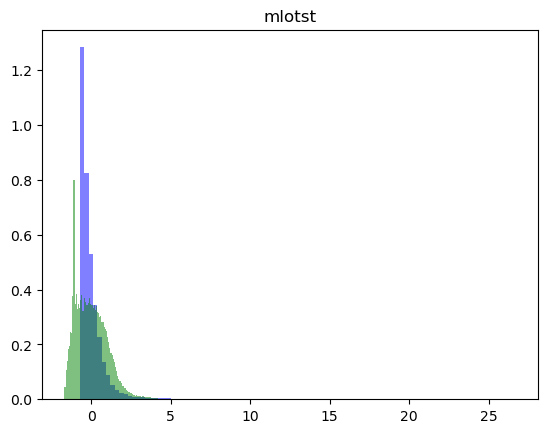

In [21]:
plt.hist(normalize(data_socat["mlotst"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["mlotst"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("mlotst")

Text(0.5, 1.0, 'chlos')

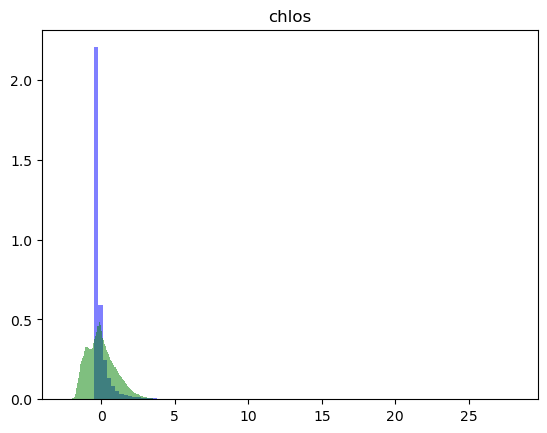

In [22]:
plt.hist(normalize(data_socat["chlos"]), 100, density=True, facecolor='blue', alpha=0.5);
plt.hist(normalize(np.log(data_socat["chlos"])), 100, density=True, facecolor='green', alpha=0.5);
plt.title("chlos")

In [23]:
for data_dict in [data_socat, data_bgcargo, data_glodap_4, data_glodap_2]:
    data_dict["mlotst"] = np.log(data_dict["mlotst"])
    data_dict["chlos"] = np.log(data_dict["chlos"])

####  Split into training and validation sets

In [24]:
np.random.seed(0)
random.seed(0)
train_valid_split = 0.833 
# As before, have 5/6 as training and 1/6 as validation data
random_indices = [np.arange(len(data_socat["tos"]), dtype=int),
                  np.arange(len(data_bgcargo["tos"]), dtype=int),
                  np.arange(len(data_glodap_4["tos"]), dtype=int),
                  np.arange(len(data_glodap_2["tos"]), dtype=int)]

for indices in random_indices:
    random.shuffle(indices)

ntrain_socat = int(len(data_socat["tos"]) * train_valid_split)
train_socat = {key: data_socat[key][random_indices[0]][:ntrain_socat]
               for key in data_socat}
valid_socat = {key: data_socat[key][random_indices[0]][ntrain_socat:]
               for key in data_socat}

ntrain_bgcargo = int(len(data_bgcargo["tos"]) * train_valid_split)
train_bgcargo = {key: data_bgcargo[key][random_indices[1]][:ntrain_bgcargo]
               for key in data_bgcargo}
valid_bgcargo = {key: data_bgcargo[key][random_indices[1]][ntrain_bgcargo:]
               for key in data_bgcargo}

ntrain_glodap_4 = int(len(data_glodap_4["tos"]) * train_valid_split)
train_glodap_4 = {key: data_glodap_4[key][random_indices[2]][:ntrain_glodap_4]
               for key in data_glodap_4}
valid_glodap_4 = {key: data_glodap_4[key][random_indices[2]][ntrain_glodap_4:]
               for key in data_glodap_4}

ntrain_glodap_2 = int(len(data_glodap_2["tos"]) * train_valid_split)
train_glodap_2 = {key: data_glodap_2[key][random_indices[3]][:ntrain_glodap_2]
               for key in data_glodap_2}
valid_glodap_2 = {key: data_glodap_2[key][random_indices[3]][ntrain_glodap_2:]
               for key in data_glodap_2}

#### normalize data and convert into feature and label arrays

In [25]:
feature_keys = ["tos", "sos", "mlotst", "zos", "chlos", "siconc", "uas", "vas",
                "co2", "mon_sin", "mon_cos", "nvector1", "nvector2", "nvector3"]

with open('../data/cmip6_base_model_train_feature_means.pkl', 'rb') as f:
    train_feature_means = pickle.load(f)

with open('../data/cmip6_base_model_train_feature_stds.pkl', 'rb') as f:
    train_feature_stds = pickle.load(f)

# normalize across the four training sets, because all four are used to train the same network
# train_feature_means = {
#     key: np.mean(np.concatenate([
#         train_socat[key], train_bgcargo[key], train_glodap_4[key], train_glodap_2[key]
#     ])) for key in feature_keys}

# train_feature_stds = {
#     key: np.std(np.concatenate([
#         train_socat[key], train_bgcargo[key], train_glodap_4[key], train_glodap_2[key]
#     ])) for key in feature_keys}

# set up train_features, valid_features, train_labels, valid_labels as dictionaries
train_features = {}
valid_features = {}
train_labels = {}
valid_labels = {}
# with keys socat, bgcargo, glodap_4, and glodap_2, containing the respective arrays
for data_key, train_data in zip(
    ["socat", "bgcargo", "glodap_4", "glodap_2"],
    [train_socat, train_bgcargo, train_glodap_4, train_glodap_2]):
    train_features[data_key] = np.concatenate([(
    train_data[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)

for data_key, valid_data in zip(
    ["socat", "bgcargo", "glodap_4", "glodap_2"],
    [valid_socat, valid_bgcargo, valid_glodap_4, valid_glodap_2]):
    valid_features[data_key] = np.concatenate([(
    valid_data[key][:, np.newaxis] - train_feature_means[key]
) / train_feature_stds[key] for key in feature_keys], axis=1)


train_labels["socat"] = train_socat["fco2"] # maybe add [:, np.newaxis]
train_labels["bgcargo"] = train_bgcargo["ph"] # maybe add [:, np.newaxis]
train_labels["glodap_4"] = np.concatenate([
    train_glodap_4[key][:, np.newaxis] for key in ["talkos_4", "dissicos_4", "sios_4", "po4os_4"]
], axis=1)
train_labels["glodap_2"] = np.concatenate([
    train_glodap_2[key][:, np.newaxis] for key in ["talkos_2", "dissicos_2"]
], axis=1)

valid_labels["socat"] = valid_socat["fco2"] # maybe add [:, np.newaxis]
valid_labels["bgcargo"] = valid_bgcargo["ph"] # maybe add [:, np.newaxis]
valid_labels["glodap_4"] = np.concatenate([
    valid_glodap_4[key][:, np.newaxis] for key in ["talkos_4", "dissicos_4", "sios_4", "po4os_4"]
], axis=1)
valid_labels["glodap_2"] = np.concatenate([
    valid_glodap_2[key][:, np.newaxis] for key in ["talkos_2", "dissicos_2"]
], axis=1)

In [26]:
# add additional dictionaries train_TS and valid_TS that only contain T and S normalized
# for surrogate models
train_TS = {}
valid_TS = {}

for data_key, train_data in zip(
    ["socat", "bgcargo"],
    [train_socat, train_bgcargo]):
    train_TS[data_key] = np.concatenate([
    (train_data[key][:, np.newaxis] - sample_means[key]) / sample_stds[key]
        for key in ["tos", "sos"]], axis=1)

for data_key, valid_data in zip(
    ["socat", "bgcargo"],
    [valid_socat, valid_bgcargo]):
    valid_TS[data_key] = np.concatenate([
    (valid_data[key][:, np.newaxis] - sample_means[key]) / sample_stds[key]
        for key in ["tos", "sos"]], axis=1)

In [27]:
print(np.mean(train_TS["socat"][:, 0]))
print(np.std(train_TS["socat"][:, 0]))
print(np.mean(train_TS["socat"][:, 1]))
print(np.std(train_TS["socat"][:, 1]))

print(np.mean(train_TS["bgcargo"][:, 0]))
print(np.std(train_TS["bgcargo"][:, 0]))
print(np.mean(train_TS["bgcargo"][:, 1]))
print(np.std(train_TS["bgcargo"][:, 1]))

0.10508837
0.88679993
0.38822964
0.16089724
-0.42586675
0.87684035
0.3899688
0.07397248


In [28]:
train_TS["socat"].shape

(270138, 2)

In [29]:
print("Check shapes of matrices.")
for key in ["socat", "bgcargo", "glodap_4", "glodap_2"]:
    print(key)
    print(train_features[key].shape)
    print(valid_features[key].shape)
    print(train_labels[key].shape)
    print(valid_labels[key].shape)
    print("--------")

Check shapes of matrices.
socat
(270138, 14)
(54158, 14)
(270138,)
(54158,)
--------
bgcargo
(7871, 14)
(1578, 14)
(7871,)
(1578,)
--------
glodap_4
(8853, 14)
(1776, 14)
(8853, 4)
(1776, 4)
--------
glodap_2
(3297, 14)
(662, 14)
(3297, 2)
(662, 2)
--------


In [30]:
print("Check normalization of features, given that it is calculated over all four data sets.")
for key in ["socat", "bgcargo", "glodap_4", "glodap_2"]:
    print(key)
    print(np.mean(train_features[key], axis=0))
    print(np.std(train_features[key], axis=0))
    print(np.mean(valid_features[key], axis=0))
    print(np.std(valid_features[key], axis=0))
    print("--------")

Check normalization of features, given that it is calculated over all four data sets.
socat
[ 0.3310729   0.31367438 -0.11051478  0.62111851  0.23004643 -0.39209877
 -0.11175582 -0.04413324  0.32820823 -0.00463562 -0.0036619   0.42707331
 -0.1474093   0.14421784]
[0.83236141 1.04530271 0.6885989  0.81611698 0.6466959  0.21768168
 0.70016144 0.74074722 0.87113164 0.99659538 1.00337704 0.8440208
 0.95779843 1.09923154]
[ 0.33069907  0.31003188 -0.11447119  0.62024651  0.23061405 -0.39265491
 -0.11745429 -0.04665359  0.32464282 -0.00542253 -0.00822185  0.43092135
 -0.14891047  0.15014118]
[0.83392625 1.04288861 0.68907971 0.81466962 0.6478509  0.21493923
 0.69934181 0.74080309 0.87268448 0.99560934 1.00432624 0.84263484
 0.95598216 1.09848608]
--------
bgcargo
[-0.16728823  0.32497331  0.41016418  0.22086302  0.07938411 -0.39257543
  0.42018827 -0.13825112  1.42441218 -0.011216    0.0710112  -0.68532769
 -0.13815271  0.00160986]
[0.82301331 0.48057777 0.6731657  0.97036451 0.40485685 0.22

# Define neural network and training procedure

In [31]:
class flexible_MLP(nn.Module):
    def __init__(self, input_size, hidden_size_part1, inner_output_size, hidden_size_part2):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_part1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_part1, hidden_size_part1, device=self.device)
        self.linear3 = nn.Linear(hidden_size_part1, hidden_size_part1, device=self.device)
        self.linear4 = nn.Linear(hidden_size_part1, inner_output_size, device=self.device)
        
        self.linear1_socat = nn.Linear(inner_output_size + 2, hidden_size_part2, device=self.device)
        self.linear2_socat = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear3_socat = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear4_socat = nn.Linear(hidden_size_part2, 1, device=self.device)

        self.linear1_bgcargo = nn.Linear(inner_output_size + 2, hidden_size_part2, device=self.device)
        self.linear2_bgcargo = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear3_bgcargo = nn.Linear(hidden_size_part2, hidden_size_part2, device=self.device)
        self.linear4_bgcargo = nn.Linear(hidden_size_part2, 1, device=self.device)
    
    def forward(self, x, TS_data=None, mode=None):
        """
        mode can be socat, bgcargo, defaults to None
        (i.e., only the first part of the network is used,
        for the GLODAP data sets)
        TS_data only needs to be provided if mode is not None
        """
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = self.linear4(x)
        if mode == "socat":
            x_p1 = x[:, :2]
            x_p2 = x[:, 2:]
            x = torch.cat((x_p1, TS_data, x_p2), dim=-1)
            x = F.elu(self.linear1_socat(x))
            x = F.elu(self.linear2_socat(x))
            x = F.elu(self.linear3_socat(x))
            x = F.elu(self.linear4_socat(x))
        if mode == "bgcargo":
            x_p1 = x[:, :2]
            x_p2 = x[:, 2:]
            x = torch.cat((x_p1, TS_data, x_p2), dim=-1)
            x = F.elu(self.linear1_bgcargo(x))
            x = F.elu(self.linear2_bgcargo(x))
            x = F.elu(self.linear3_bgcargo(x))
            x = F.elu(self.linear4_bgcargo(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [32]:
model = flexible_MLP(14, 160, 4, 160)
print(model)

print("Update the base, socat and bgcargo subnets and freeze these layers")
base_state_dict = torch.load("../models/CMIP6_base_model_160x3_elu_10000epo.pth")
socat_state_dict = torch.load("../models/fCO2_model_160x3_elu_10000epo.pth")
bgcargo_state_dict = torch.load("../models/pH_model_160x3_elu_10000epo.pth")

with torch.no_grad(): # not sure whether interfers with autograd
    model.linear1.weight.copy_(base_state_dict["linear1.weight"])
    model.linear1.bias.copy_(base_state_dict["linear1.bias"])
    model.linear2.weight.copy_(base_state_dict["linear2.weight"])
    model.linear2.bias.copy_(base_state_dict["linear2.bias"])
    model.linear3.weight.copy_(base_state_dict["linear3.weight"])
    model.linear3.bias.copy_(base_state_dict["linear3.bias"])
    model.linear4.weight.copy_(base_state_dict["linear4.weight"])
    model.linear4.bias.copy_(base_state_dict["linear4.bias"])
    
    model.linear1_socat.weight.copy_(socat_state_dict["linear1.weight"])
    model.linear1_socat.bias.copy_(socat_state_dict["linear1.bias"])
    model.linear2_socat.weight.copy_(socat_state_dict["linear2.weight"])
    model.linear2_socat.bias.copy_(socat_state_dict["linear2.bias"])
    model.linear3_socat.weight.copy_(socat_state_dict["linear3.weight"])
    model.linear3_socat.bias.copy_(socat_state_dict["linear3.bias"])
    model.linear4_socat.weight.copy_(socat_state_dict["linear4.weight"])
    model.linear4_socat.bias.copy_(socat_state_dict["linear4.bias"])

    model.linear1_bgcargo.weight.copy_(bgcargo_state_dict["linear1.weight"])
    model.linear1_bgcargo.bias.copy_(bgcargo_state_dict["linear1.bias"])
    model.linear2_bgcargo.weight.copy_(bgcargo_state_dict["linear2.weight"])
    model.linear2_bgcargo.bias.copy_(bgcargo_state_dict["linear2.bias"])
    model.linear3_bgcargo.weight.copy_(bgcargo_state_dict["linear3.weight"])
    model.linear3_bgcargo.bias.copy_(bgcargo_state_dict["linear3.bias"])
    model.linear4_bgcargo.weight.copy_(bgcargo_state_dict["linear4.weight"])
    model.linear4_bgcargo.bias.copy_(bgcargo_state_dict["linear4.bias"])

model.linear1_socat.weight.requires_grad = False
model.linear1_socat.bias.requires_grad = False
model.linear2_socat.weight.requires_grad = False
model.linear2_socat.bias.requires_grad = False
model.linear3_socat.weight.requires_grad = False
model.linear3_socat.bias.requires_grad = False
model.linear4_socat.weight.requires_grad = False
model.linear4_socat.bias.requires_grad = False

model.linear1_bgcargo.weight.requires_grad = False
model.linear1_bgcargo.bias.requires_grad = False
model.linear2_bgcargo.weight.requires_grad = False
model.linear2_bgcargo.bias.requires_grad = False
model.linear3_bgcargo.weight.requires_grad = False
model.linear3_bgcargo.bias.requires_grad = False
model.linear4_bgcargo.weight.requires_grad = False
model.linear4_bgcargo.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

flexible_MLP(
  (linear1): Linear(in_features=14, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=4, bias=True)
  (linear1_socat): Linear(in_features=6, out_features=160, bias=True)
  (linear2_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear3_socat): Linear(in_features=160, out_features=160, bias=True)
  (linear4_socat): Linear(in_features=160, out_features=1, bias=True)
  (linear1_bgcargo): Linear(in_features=6, out_features=160, bias=True)
  (linear2_bgcargo): Linear(in_features=160, out_features=160, bias=True)
  (linear3_bgcargo): Linear(in_features=160, out_features=160, bias=True)
  (linear4_bgcargo): Linear(in_features=160, out_features=1, bias=True)
)
Update the base, socat and bgcargo subnets and freeze these layers
Number of trainable parameters in the model: 54564


In [33]:
def training_dataloader(features, labels, batch_size, TS=None):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    if TS is None:
        batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                      for ind in batch_indices]
    elif TS is not None:
        batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(labels, ind, axis=0).astype("float32")).to(torch.device("cuda")),
                       torch.from_numpy(np.take(TS, ind, axis=0).astype("float32")).to(torch.device("cuda")))
                      for ind in batch_indices]
    return batch_data

In [34]:
loss_function = nn.MSELoss()

class MSELoss_glodap_2(nn.Module):
    def __init__(self):
        super(MSELoss_glodap_2, self).__init__()

    def forward(self, input, target):
        loss = torch.mean((input[:, :2] - target) ** 2)
        return loss
loss_function_glodap_2 = MSELoss_glodap_2()

In [35]:
def train_one_epoch(optimizer, mlp_mode):
    """
    mlp_mode can be 'socat', 'bgcargo', 'glodap_4', 'glodap_2'
    """
    running_loss = 0. # running loss over all batches in the epoch

    if mlp_mode == 'socat' or mlp_mode == 'bgcargo':
        training_data = training_dataloader(train_features[mlp_mode],
                                            train_labels[mlp_mode],
                                            batch_size, train_TS[mlp_mode])
    
        for batch in training_data:
            features, labels, TS = batch
            optimizer.zero_grad()
            outputs = torch.squeeze(model(features, TS, mlp_mode))
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.detach().cpu().item()
    
    elif mlp_mode == 'glodap_4' or mlp_mode == 'glodap_2':
        training_data = training_dataloader(train_features[mlp_mode],
                                            train_labels[mlp_mode], batch_size)
    
        for batch in training_data:
            features, labels = batch
            optimizer.zero_grad()
            outputs = torch.squeeze(model(features))
            
            if mlp_mode == 'glodap_4':
                loss = loss_function(outputs, labels)
            elif mlp_mode == 'glodap_2':
                loss = loss_function_glodap_2(outputs, labels)
                
            loss.backward()
            optimizer.step()
                
            running_loss += loss.detach().cpu().item()

    ntrain = len(train_labels[mlp_mode])
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [36]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, n_epochs, optimizer, scheduler):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    for epoch in pbar:

        mlp_mode = 'socat'
        # if epoch % 4 == 0:
        #     mlp_mode = 'socat'
        # elif epoch % 4 == 1:
        #     mlp_mode = 'bgcargo'
        # elif epoch % 4 == 2:
        #     mlp_mode = 'glodap_4'
        # elif epoch % 4 == 3:
        #     mlp_mode = 'glodap_2'

        # if epoch % 2 == 0:
        #     mlp_mode = 'glodap_4'
        # elif epoch % 2 == 1:
        #     mlp_mode = 'glodap_2'

        # if epoch % 3 == 0:
        #     mlp_mode = 'socat'
        # elif epoch % 3 == 1:
        #     mlp_mode = 'glodap_4'
        # elif epoch % 3 == 2:
        #     mlp_mode = 'glodap_2'

        model.train()

        train_loss_epoch = train_one_epoch(optimizer, mlp_mode)

        model.eval()
        with torch.no_grad():
            if mlp_mode == 'socat' or mlp_mode == 'bgcargo':
                valid_outputs = torch.squeeze(model(
                    torch.from_numpy(valid_features[mlp_mode].astype("float32")).to(torch.device("cuda")),
                    torch.from_numpy(valid_TS[mlp_mode].astype("float32")).to(torch.device("cuda")),
                    mlp_mode))
                valid_loss_epoch = loss_function(
                    valid_outputs, torch.from_numpy(valid_labels[mlp_mode]
                                                   ).to(torch.device("cuda"))
                                            ).detach().cpu().item()

            elif mlp_mode == 'glodap_4' or mlp_mode == 'glodap_2':
                valid_outputs = torch.squeeze(model(
                    torch.from_numpy(valid_features[mlp_mode].astype("float32"))).to(torch.device("cuda")))
                if mlp_mode == 'glodap_4':
                    valid_loss_epoch = loss_function(
                        valid_outputs, torch.from_numpy(valid_labels[mlp_mode]
                                                       ).to(torch.device("cuda"))
                                                ).detach().cpu().item()
                if mlp_mode == 'glodap_2':
                    valid_loss_epoch = loss_function_glodap_2(
                        valid_outputs, torch.from_numpy(valid_labels[mlp_mode]
                                                       ).to(torch.device("cuda"))
                                                ).detach().cpu().item()
                
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss': f'{train_loss_epoch:.3e}',
                          'valid_loss': f'{valid_loss_epoch:.3e}',
                          'learn_rate': f'{lr:.3e}',
                          'mode': mlp_mode},
                        )

    return train_stats

# Test zero-shot inference with pretrained base model

Mostly to test whether the order of magnitude of the output fits.
Mediocre performance should be expected, given that the input features
are normalized differently to the model-based feature normalization
during the CMIP6 base model training

**On socat validation data**

In [37]:
def MSE(x, y):
    return np.sum((x - y)**2, axis=0) / len(x)

In [38]:
model.eval()
with torch.no_grad():
    model_output_zero_shot = model(
        torch.from_numpy(valid_features['socat'].astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS['socat'].astype("float32")).to(torch.device("cuda")),
        'socat').detach().cpu().numpy().squeeze()

In [39]:
print("RMSE: ", np.sqrt(MSE(valid_labels['socat'], model_output_zero_shot)))
print("Maximum absolute deviation: ", np.max(np.abs(model_output_zero_shot-valid_labels['socat'])))
print("99.9th percentile of absolute deviation (1000 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels['socat']), q=99.9))
print("99.99th percentile of absolute deviation (100 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels['socat']), q=99.99))
print("99.999th percentile of absolute deviation (10 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels['socat']), q=99.999))

RMSE:  49.52545738812077
Maximum absolute deviation:  3943.7754
99.9th percentile of absolute deviation (1000 val's larger):  287.76951257324373
99.99th percentile of absolute deviation (100 val's larger):  545.3872545286408
99.999th percentile of absolute deviation (10 val's larger):  3884.9338630125617


In [40]:
print(model_output_zero_shot[:10])
print(valid_labels['socat'][:10])

[407.1605  443.2639  396.05356 437.08728 259.41373 365.39157 407.44818
 382.3938  346.84412 406.29935]
[576.479   390.8506  393.4201  454.84305 136.84183 340.29868 376.43567
 351.80457 380.99127 380.20386]


**On bgcargo data**

In [41]:
model.eval()
with torch.no_grad():
    model_output_zero_shot = model(
        torch.from_numpy(valid_features['bgcargo'].astype("float32")).to(torch.device("cuda")),
        torch.from_numpy(valid_TS['bgcargo'].astype("float32")).to(torch.device("cuda")),
        'bgcargo').detach().cpu().numpy().squeeze()

In [42]:
print("RMSE: ", np.sqrt(MSE(valid_labels['bgcargo'], model_output_zero_shot)))
print("Maximum absolute deviation: ", np.max(np.abs(model_output_zero_shot-valid_labels['bgcargo'])))
print("99.9th percentile of absolute deviation (1000 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels['bgcargo']), q=99.9))
print("99.99th percentile of absolute deviation (100 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels['bgcargo']), q=99.99))
print("99.999th percentile of absolute deviation (10 val's larger): ",
      np.percentile(np.abs(model_output_zero_shot-valid_labels['bgcargo']), q=99.999))

RMSE:  0.037845265331573764
Maximum absolute deviation:  0.2852664
99.9th percentile of absolute deviation (1000 val's larger):  0.22117809343338324
99.99th percentile of absolute deviation (100 val's larger):  0.27639395461081306
99.999th percentile of absolute deviation (10 val's larger):  0.2843791549062615


In [43]:
print(model_output_zero_shot[:10])
print(valid_labels['bgcargo'][:10])

[8.058367 8.030563 8.051839 8.047309 8.001977 8.02157  8.010197 8.021605
 8.02684  8.035014]
[8.045084 8.052956 8.052579 8.127767 8.002916 8.004313 8.097033 8.007573
 8.072128 8.059124]


**On glodap_4 data**

In [44]:
sample_means_array = np.concatenate(
    [np.array(sample_means[key])[np.newaxis]
     for key in ['talkos', 'dissicos', 'sios', 'po4os']], axis=0)
sample_stds_array = np.concatenate(
    [np.array(sample_stds[key])[np.newaxis]
     for key in ['talkos', 'dissicos', 'sios', 'po4os']], axis=0)

def denormalize(array, mode):
    if mode == 'glodap_4':
        return array * sample_stds_array + sample_means_array
    elif mode == 'glodap_2':
        return array * sample_stds_array[:2] + sample_means_array[:2]

In [45]:
model.eval()
with torch.no_grad():
    model_output_zero_shot = model(
        torch.from_numpy(valid_features['glodap_4'].astype("float32")).to(torch.device("cuda"))).detach().cpu().numpy().squeeze()

In [46]:
valid_labels_den = denormalize(valid_labels['glodap_4'] * 1e6, mode="glodap_4")
model_output_den = denormalize(model_output_zero_shot * 1e6, mode="glodap_4")

print("RMSE: ", np.sqrt(MSE(valid_labels_den, model_output_den)))
print("Maximum absolute deviation: ", np.max(np.abs(model_output_den-valid_labels_den), axis=0))
print("99.9th percentile of absolute deviation (1000 val's larger): ",
      np.percentile(np.abs(model_output_den-valid_labels_den), q=99.9, axis=0))
print("99.99th percentile of absolute deviation (100 val's larger): ",
      np.percentile(np.abs(model_output_den-valid_labels_den), q=99.99, axis=0))
print("99.999th percentile of absolute deviation (10 val's larger): ",
      np.percentile(np.abs(model_output_den-valid_labels_den), q=99.999, axis=0))

RMSE:  [126.62722705 114.52967997  15.02838226   0.2515668 ]
Maximum absolute deviation:  [1124.19378317 1028.12749456   73.24865607    1.55872371]
99.9th percentile of absolute deviation (1000 val's larger):  [1009.59302849  937.02611229   68.60630453    1.43207095]
99.99th percentile of absolute deviation (100 val's larger):  [1122.16800022 1027.12301468   72.70113177    1.54956495]
99.999th percentile of absolute deviation (10 val's larger):  [1123.99120487 1028.02704657   73.19390364    1.55780784]


In [47]:
print(denormalize(model_output_zero_shot[:10], mode="glodap_4") * 1e6)
print(denormalize(valid_labels['glodap_4'][:10], mode="glodap_4") * 1e6)

[[2.23735301e+03 1.91318370e+03 2.04176155e-01 3.11383323e-01]
 [2.23008402e+03 2.04454534e+03 7.71943942e+00 3.75820524e-01]
 [1.86242671e+03 1.78213851e+03 9.28035386e+00 5.39205140e-01]
 [2.33585014e+03 1.99831239e+03 3.57926437e-01 2.33965906e-01]
 [2.04701333e+03 1.86544010e+03 1.99177335e+00 1.48818282e-01]
 [2.33363719e+03 2.00703735e+03 1.38180316e+00 4.28470852e-02]
 [2.25748142e+03 1.94424458e+03 6.83546437e-02 1.58000156e-01]
 [1.69120541e+03 1.62212363e+03 9.42533805e+00 5.40125887e-01]
 [2.20542384e+03 2.05799018e+03 7.21454744e+01 1.17687629e+00]
 [2.21858560e+03 1.94336688e+03 1.19687120e+00 1.74443122e-01]]
[[2.22579986e+03 1.89510000e+03 1.13299534e+00 3.04500957e-02]
 [2.30899652e+03 2.14166988e+03 4.23249627e+00 5.84999848e-01]
 [1.92655194e+03 1.84019794e+03 2.60405842e+00 5.39999937e-01]
 [2.40599982e+03 2.04880001e+03 2.37594315e-01 2.59999983e-01]
 [2.15943334e+03 1.92696670e+03 3.22333884e+00 2.76666632e-01]
 [2.37285012e+03 2.05594998e+03 1.05000099e+00 1.04999

**On glodap_2 data**

In [48]:
model.eval()
with torch.no_grad():
    model_output_zero_shot = model(
        torch.from_numpy(valid_features['glodap_2'].astype("float32")).to(torch.device("cuda"))).detach().cpu().numpy().squeeze()

In [49]:
print(denormalize(model_output_zero_shot[:10, :2], mode="glodap_2") * 1e6)
print(denormalize(valid_labels['glodap_2'][:10], mode="glodap_2") * 1e6)

[[2207.19300265 2099.22985625]
 [2359.33010103 2022.56361374]
 [2199.57764864 2051.43920655]
 [2291.78092039 1975.34273076]
 [2381.73438929 2061.84124727]
 [2360.92664651 2020.50953082]
 [2197.17653288 1883.696759  ]
 [2359.53864234 2022.959123  ]
 [2199.48788296 2078.12677736]
 [2291.65755065 2044.08711834]]
[[2304.69988259 2198.20000348]
 [2394.89988448 2044.10010223]
 [2289.30000145 2089.86668441]
 [2383.66112518 2058.85432181]
 [2428.14969745 2091.44993048]
 [2378.79987578 2025.60005671]
 [2243.80000381 1922.09997749]
 [2403.99982206 2053.49991282]
 [2285.60007939 2153.49999266]
 [2330.49984971 2069.50006017]]


# Training

#### First fully retrain the base network (no transfer learning case)

In [51]:
batch_size = 1000
n_epochs = 10_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [1:01:09<00:00,  2.72it/s, epoch=10000/10000, train_loss=1.079e+02, valid_loss=1.251e+03, learn_rate=1.000e-05, mode=socat]


#### Freeze all layers of the base model despite the last linear projection layer and train it

In [202]:
model.linear1.weight.requires_grad = False
model.linear1.bias.requires_grad = False
model.linear2.weight.requires_grad = False
model.linear2.bias.requires_grad = False
model.linear3.weight.requires_grad = False
model.linear3.bias.requires_grad = False

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

Number of trainable parameters in the model: 644


In [203]:
batch_size = 1000
n_epochs = 1_000

base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 500)

#optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=base_learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

train_stats = train(batch_size, n_epochs, optimizer, scheduler)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [01:46<00:00,  9.37it/s, epoch=1000/1000, train_loss=8.926e+02, valid_loss=1.822e+03, learn_rate=1.005e-05, mode=socat]
